In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png)

safediv(x, y) = x == 0 ? zero(x/y) : x/y

hedgesg(m, x̄, u, n, ȳ, v) = safediv(abs(x̄ - ȳ), √(((m-1)*u+(n-1)*v)/(m+n-2)))
hedgesg(x, y) = hedgesg(length(x), mean(x), var(x), length(y), mean(y), var(y))

function pvalue_student_t(m, x̄, u, n, ȳ, v)
    t = safediv(x̄ - ȳ, √(((m-1)*u+(n-1)*v)/(m+n-2)) * √(1/m+1/n))
    2ccdf(TDist(m+n-2), abs(t))
end
pvalue_student_t(x, y) = pvalue_student_t(length(x), mean(x), var(x), length(y), mean(y), var(y))

function sim(m, n=m; L=10^6)
    Pval = zeros(L)
    Hedgesg = zeros(L)
    nth = Threads.nthreads()
    Xtmp = [zeros(m) for _ in 1:nth]
    Ytmp = [zeros(n) for _ in 1:nth]
    Threads.@threads :static for i in 1:L
        tid = Threads.threadid()
        X = randn!(Xtmp[tid])
        Y = randn!(Ytmp[tid])
        Pval[i] = pvalue_student_t(X, Y)
        Hedgesg[i] = hedgesg(X, Y)
    end
    Pval, Hedgesg
end

sim (generic function with 2 methods)

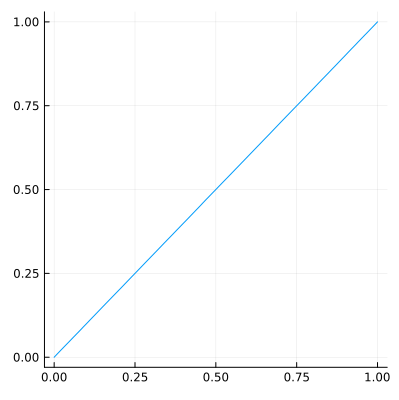

In [2]:
Pval, Hedgesg = sim(10)
plot(0:0.01:1, α->count(<(α), Pval)/length(Pval); label="", size=(400, 400))

In [3]:
function plot_Hedgesg(;
        α = 0.05,
        ms = 10:10:200,
        xtick = 0:10:200,
        ytick = 0:0.1:1.6,
        ylim = (-0.03, 1.6),
        L = 10^5,
        kwargs...
    )
    g0025 = zeros(length(ms))
    g0500 = zeros(length(ms))
    g0975 = zeros(length(ms))
    for (i, m) in enumerate(ms)
        Pval, Hedgesg = sim(m; L)
        G = Hedgesg[Pval .< α]
        g0025[i], g0500[i], g0975[i] = quantile.((G,), (0.025, 0.500, 0.975))
    end

    plot(ms, g0500; label="median")
    plot!(ms, g0025; c=2, ls=:dot, label="95% limits")
    plot!(ms, g0975; c=2, ls=:dot, label="")
    plot!(xguide="sample size m = n")
    title!("Hedges' g for α = $α")
    plot!(; xtick, ytick, ylim, kwargs...)
end

plot_Hedgesg (generic function with 1 method)

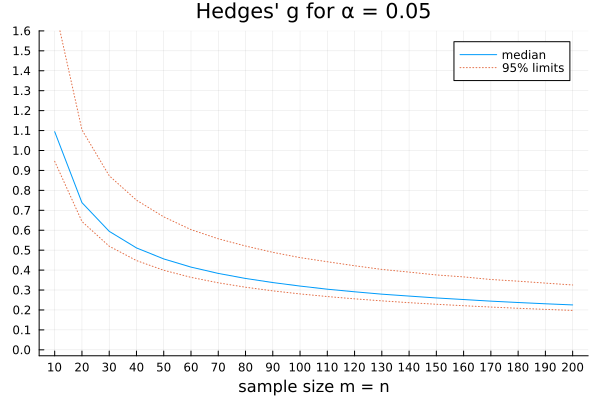

In [4]:
plot_Hedgesg(; ms = 10:10:200, xtick = 0:10:200, ytick = 0:0.1:1.6, ylim = (-0.03, 1.6), L = 10^6)

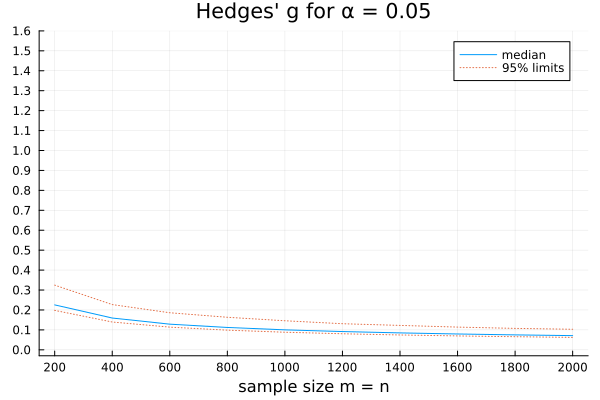

In [5]:
plot_Hedgesg(; ms = 200:200:2000, xtick = 0:200:2000, ytick = 0:0.1:1.6, ylim = (-0.03, 1.6))

In [6]:
function plot_Hedgesg_fixed_samplesize(m, n=m; L=10^6, ytick=0:0.1:1.6, ylim=(-0.03, 1.6), kwargs...)
    Pval, Hedgesg = sim(m, n; L)
    αs = 0.01:0.01:1
    g0025 = zeros(length(αs))
    g0500 = zeros(length(αs))
    g0975 = zeros(length(αs))
    for (i, α) in enumerate(αs)
        G = Hedgesg[Pval .< α]
        g0025[i], g0500[i], g0975[i] = quantile.((G,), (0.025, 0.500, 0.975))
    end
    plot(αs, g0500; label="median")
    plot!(αs, g0025; c=2, ls=:dot, label="95% limits")
    plot!(αs, g0975; c=2, ls=:dot, label="")
    plot!(xguide="α")
    plot!(xtick=0:0.1:1)
    plot!(; ytick, ylim, kwargs...)
    title!("Hedges' g for m = $m, n = $n")
end

plot_Hedgesg_fixed_samplesize (generic function with 2 methods)

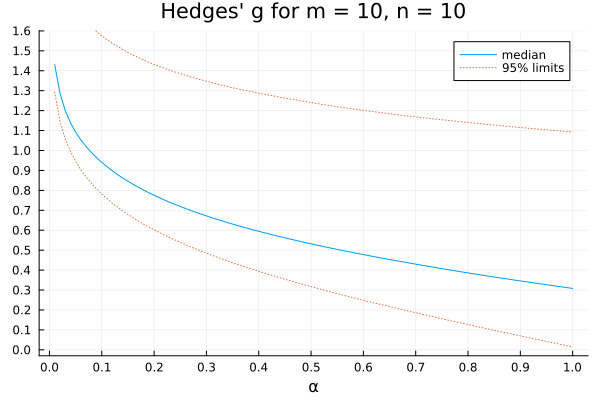

In [7]:
plot_Hedgesg_fixed_samplesize(10)

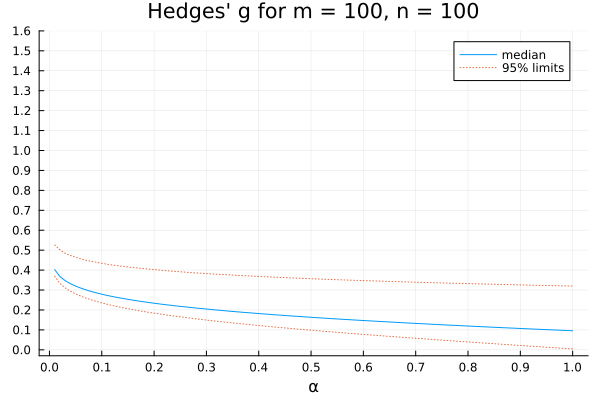

In [8]:
plot_Hedgesg_fixed_samplesize(100)